In [1]:
import h5py
import librosa
import numpy as np

file = h5py.File('dataset.h5', 'r')
#label_dict = {"['n']": 0, "['c']": 1, "['h']": 2, "['s']": 3,
 #             "['a']": 4, "['f']": 5, "['d']": 6, "['su']": 7}

labels = file['label'][:36406].squeeze()
print('done!')
relevant_indexes =  np.where((labels != 6) & (labels != 7))

print('done!')
y = file['label'][relevant_indexes]
print('done!')
X = file['mfcc'][relevant_indexes]
print('done!')

X.shape, y.shape

done!
done!
done!
done!


((28388, 12, 42), (28388, 1))

In [2]:
# extract delta and double delta features using librosa
X_deltas = np.zeros((X.shape[0], X.shape[1]*3, X.shape[2]))
print(X_deltas.shape)
for i in range(X.shape[0]):
    X_delta = librosa.feature.delta(X[i])
    X_delta2 = librosa.feature.delta(X[i], order=2)
    # np.vstack all the X, X_delta and X_delta2 
    new_features = np.vstack([X[i], X_delta, X_delta2])
    X_deltas[i] = new_features
    # print(X_deltas[i].shape)

(28388, 36, 42)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_deltas, y, test_size=0.33, random_state=32)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19019, 36, 42), (9369, 36, 42), (19019, 1), (9369, 1))

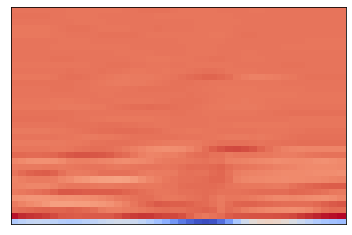

array([[-1.52528137e+02, -1.54594147e+02, -1.62320389e+02, ...,
        -2.85712402e+02, -2.89845276e+02, -3.00263458e+02],
       [ 1.40125595e+02,  1.40075668e+02,  1.37851898e+02, ...,
         1.10869392e+02,  1.11067955e+02,  1.10900208e+02],
       [-6.84786301e+01, -6.82664642e+01, -6.62973328e+01, ...,
        -3.10423012e+01, -3.06803570e+01, -3.06496048e+01],
       ...,
       [-1.73263758e-01, -1.73263758e-01, -1.73263758e-01, ...,
        -6.40835166e-02, -6.40835166e-02, -6.40835166e-02],
       [-5.61701536e-01, -5.61701536e-01, -5.61701536e-01, ...,
        -2.87273884e-01, -2.87273884e-01, -2.87273884e-01],
       [ 1.42646298e-01,  1.42646298e-01,  1.42646298e-01, ...,
        -2.97414690e-01, -2.97414690e-01, -2.97414690e-01]])

In [4]:
import librosa.display
import matplotlib.pyplot as plt
librosa.display.specshow(X_train[1])
plt.show()
X_train[0]

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten, Dropout, Permute
from keras.layers import Conv2D, MaxPooling2D, Reshape, AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import adam_v2
import keras

# import rms prop from keras


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
opt = adam_v2.Adam(learning_rate=0.00005)
# model.compile(loss='categorical_crossentropy', optimizer=opt)

feature_shape = X_train[0].shape
print(feature_shape)
model = Sequential()
model.add(Reshape(target_shape=(
    feature_shape[0], feature_shape[1], 1), input_shape=(feature_shape[0], feature_shape[1])))
# 1st conv layer
model.add(Conv2D(16, (5, 5), activation='relu', strides=(2, 1), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.1))


# 2nd conv layer
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 1), padding='same'))
# model.add(Dropout(0.2))
model.add(Dropout(0.1))

# 3rd conv layer
model.add(Conv2D(64, (2, 2), activation='relu', strides=(1, 1), padding='same'))
# model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.2))

# 4th conv layer
model.add(Conv2D(128, (2, 2), activation='relu',
          strides=(1, 1), padding='same'))
# model.add(MaxPooling2D((2, 1)))

# model.add(BatchNormalization())

# flatten the output and add a dense layer
model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

# outout layer
model.add(Dense(6, activation='softmax'))
model.summary()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])


(36, 42)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_42 (Reshape)        (None, 36, 42, 1)         0         
                                                                 
 conv2d_168 (Conv2D)         (None, 18, 42, 16)        416       
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 9, 21, 16)        0         
 g2D)                                                            
                                                                 
 dropout_101 (Dropout)       (None, 9, 21, 16)         0         
                                                                 
 conv2d_169 (Conv2D)         (None, 9, 21, 32)         4640      
                                                                 
 dropout_102 (Dropout)       (None, 9, 21, 32)         0         
                                            

In [114]:
cnnhistory=model.fit(X_train, y_train, batch_size=1000, epochs=200,validation_data=(X_test, y_test), callbacks=[es], verbose=1)


Epoch 1/200
20/20 [==============================] - 4s 125ms/step - loss: 1.6594 - accuracy: 0.2684 - val_loss: 1.5382 - val_accuracy: 0.3374
Epoch 2/200
20/20 [==============================] - 2s 102ms/step - loss: 1.5493 - accuracy: 0.3306 - val_loss: 1.4592 - val_accuracy: 0.3745
Epoch 3/200
20/20 [==============================] - 2s 99ms/step - loss: 1.4965 - accuracy: 0.3542 - val_loss: 1.4284 - val_accuracy: 0.3801
Epoch 4/200
20/20 [==============================] - 2s 99ms/step - loss: 1.4646 - accuracy: 0.3684 - val_loss: 1.3923 - val_accuracy: 0.4067
Epoch 5/200
20/20 [==============================] - 2s 102ms/step - loss: 1.4377 - accuracy: 0.3835 - val_loss: 1.3999 - val_accuracy: 0.3934
Epoch 6/200
20/20 [==============================] - 2s 101ms/step - loss: 1.4213 - accuracy: 0.3887 - val_loss: 1.3537 - val_accuracy: 0.4206
Epoch 7/200
20/20 [==============================] - 2s 102ms/step - loss: 1.4166 - accuracy: 0.3952 - val_loss: 1.3418 - val_accuracy: 0.4268
E

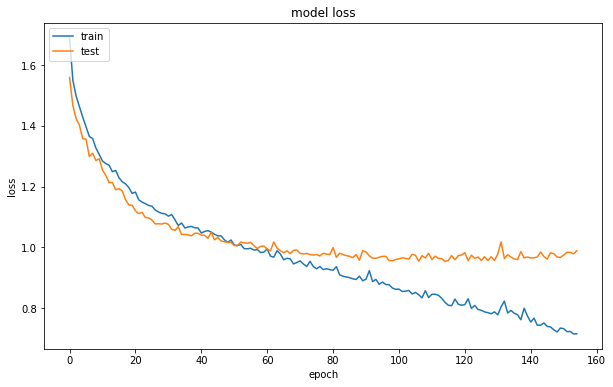

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

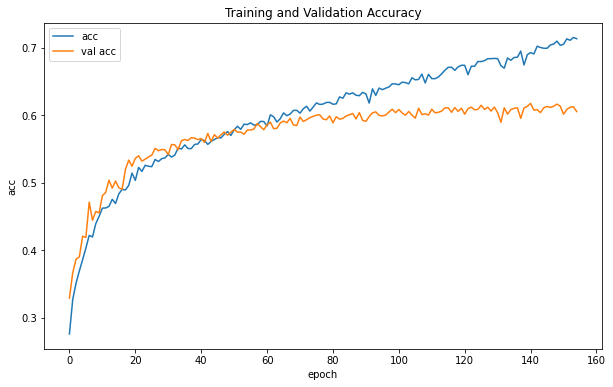

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['acc', 'val acc'], loc='upper left')
plt.show()

In [75]:
# save the model history
cnnhistory.model.save('cnn_61.h5')